In [55]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm

image_size = 64
lr = 0.001
epochs = 10
batch_size = 64
latent_size = 64
device = torch.device("mps")
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

celeb_dataset = datasets.celeba.CelebA("data3", split='train', download=True, transform=transforms.Compose([ transforms.Resize((image_size, image_size)),
                                                        transforms.CenterCrop(image_size),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(*stats)]))


cat_dataset = datasets.CIFAR10("data6", train=True, download=True, transform=transforms.Compose([ transforms.Resize((image_size, image_size)),
                                                        transforms.CenterCrop(image_size),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(*stats)]))
#combine cat and celeb dataset
dataset = torch.utils.data.ConcatDataset([celeb_dataset])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(64, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, x):
        return self.generator(x)


class Descriminator(nn.Module):
    def __init__(self):
        super(Descriminator, self).__init__()
        self.descriminator = nn.Sequential(
            # in: 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.descriminator(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


100%|██████████| 2544/2544 [03:55<00:00, 10.78it/s]


Saving generated-images-0001.png
Epoch 0 finished


100%|██████████| 2544/2544 [03:59<00:00, 10.62it/s]


Saving generated-images-0002.png
Epoch 1 finished


100%|██████████| 2544/2544 [03:56<00:00, 10.75it/s]


Saving generated-images-0003.png
Epoch 2 finished


100%|██████████| 2544/2544 [03:57<00:00, 10.71it/s]


Saving generated-images-0004.png
Epoch 3 finished


100%|██████████| 2544/2544 [03:56<00:00, 10.76it/s]


Saving generated-images-0005.png
Epoch 4 finished


100%|██████████| 2544/2544 [03:57<00:00, 10.70it/s]


Saving generated-images-0006.png
Epoch 5 finished


100%|██████████| 2544/2544 [03:56<00:00, 10.76it/s]


Saving generated-images-0007.png
Epoch 6 finished


100%|██████████| 2544/2544 [03:58<00:00, 10.66it/s]


Saving generated-images-0008.png
Epoch 7 finished


100%|██████████| 2544/2544 [03:56<00:00, 10.76it/s]


Saving generated-images-0009.png
Epoch 8 finished


100%|██████████| 2544/2544 [03:55<00:00, 10.78it/s]


Saving generated-images-0010.png
Epoch 9 finished


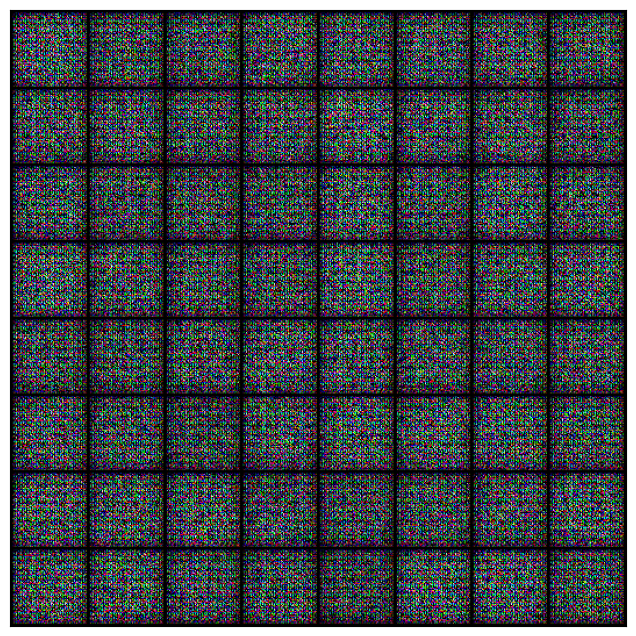

In [57]:
generator = Generator().to(device)
discriminator = Descriminator().to(device)

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


def train_descriminator(optimizer, real_images):
    optimizer.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()


def train_generator(optimizer):
    optimizer.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    optimizer.step()

def train(epochs, start_idx=1):
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    save_samples(0, fixed_latent)

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(tqdm(dataloader)):
            real_images = real_images.to(device)
            train_descriminator(opt_d, real_images)
            train_generator(opt_g)

        save_samples(epoch+start_idx, fixed_latent, show=True)
        print(f"Epoch {epoch} finished")

train(epochs)